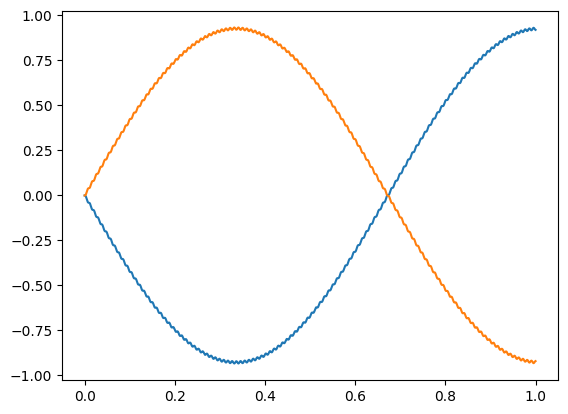

In [57]:
# this paper! https://journals.aps.org/pra/pdf/10.1103/PhysRevA.101.052308
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# %%
sx1 = qt.tensor(qt.sigmax(), qt.qeye(2))
sy1 = qt.tensor(qt.sigmay(), qt.qeye(2))
sz1 = qt.tensor(qt.sigmaz(), qt.qeye(2))
sp1 = qt.tensor(qt.sigmap(), qt.qeye(2))
sm1 = qt.tensor(qt.sigmam(), qt.qeye(2))

sx2 = qt.tensor(qt.qeye(2), qt.sigmax())
sy2 = qt.tensor(qt.qeye(2), qt.sigmay())
sz2 = qt.tensor(qt.qeye(2), qt.sigmaz())
sp2 = qt.tensor(qt.qeye(2), qt.sigmap())
sm2 = qt.tensor(qt.qeye(2), qt.sigmam())


e_op_list = []
e_op_list.extend((sx1, sy1, sz1))
e_op_list.extend((sx2, sy2, sz2))

# Detuning between qubit 1 and 2
Delta12 = 100*2*np.pi
# Static coupling between qubit 1 and 2
J12 = 2*2*np.pi
# m2 sets the strength of spurious drive on qubit 2
m1 = 1.0
m2 = 0.2*0
# Drive strength on qubit 1
Omega = 20*2*np.pi
 
# (Time indenpendent) Hamiltonian in frame rotating at omega 2
Hp = Delta12/2*sz1 + J12*(sp1*sm2 + sm1*sp2) + m1*Omega*sx1 + m2*Omega*sx2

H0 = -Delta12/2*sz2 + J12*(sp1*sm2 + sm1*sp2)
Htp = [H0, [Omega*(m1*sp1+m2*sp2), lambda t, args: np.exp(1j*Delta12*t)],
       [Omega*(m1*sm1+m2*sm2), lambda t, args: np.exp(-1j*Delta12*t)]]

# Initial states
# |00>
psidown = qt.tensor(qt.basis(2, 1), qt.basis(2, 1))
# |10>
psiup = qt.tensor(qt.basis(2, 0), qt.basis(2, 1))


def CR(tlist, psi0):
    # Simple CR gate
    output = qt.mesolve(Hp, psi0, tlist, [], e_op_list)
    return(output.expect)
endtime = 1 #us
tlist = np.linspace(0.0, endtime, 1001)
output_00 = CR(tlist, psidown)
output_10 = CR(tlist, psiup)

plt.plot(tlist, output_00[4])
plt.plot(tlist, output_10[4])

In [56]:
import pennylane as qml
from pennylane import numpy as np

# Define the device with 2 qubits
dev = qml.device('default.qubit', wires=2)

# Define the angle for the CRX gate (in radians)
theta = 0.6  # Example angle; you can change this

def rzx(theta, wires):
    # Apply the RZX gate using decomposition
    qml.CNOT(wires=wires)       # CNOT gate
    qml.RX(theta, wires=wires[1]) # RX gate on target
    qml.CNOT(wires=wires)       # CNOT gate

@qml.qnode(dev)
def circuit():
    # Apply CRX gate
    # qml.X(wires = 0)
    qml.ECR(wires=[0, 1])
    
    # Return the probability of measuring |1> on the target qubit (qubit 1)
    return qml.expval(qml.PauliX(1)), qml.expval(qml.PauliY(1)), qml.expval(qml.PauliZ(1))

# Execute the circuit
expval_x, expval_y, expval_z = circuit()

print(f"Expectation value for Pauli X on the target qubit: {expval_x:.4f}")
print(f"Expectation value for Pauli Y on the target qubit: {expval_y:.4f}")
print(f"Expectation value for Pauli Z on the target qubit: {expval_z:.4f}")


Expectation value for Pauli X on the target qubit: 0.0000
Expectation value for Pauli Y on the target qubit: -1.0000
Expectation value for Pauli Z on the target qubit: 0.0000


In [2]:
# Let's estimate a drive power
import numpy as np
wq = 4e9 * 2*np.pi
cd = 0.1e-15
Z0 = 50
csigma = 90e-15
gamma_purcell_driveline = wq**2 * cd**2 * Z0**2 / csigma

In [20]:
from scipy.constants import hbar
power = 0.0000000000001
omega = np.sqrt(4 * gamma_purcell_driveline * power / hbar / wq)

In [21]:
omega/1e9 / 2/np.pi

0.025898864665310477

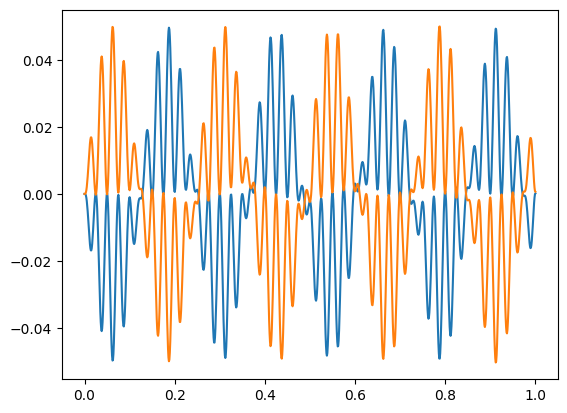

In [21]:
# Parameters
omega1 = 4000.0 *2*np.pi   # omega1
omega2 = 4000.1 *2*np.pi # omega2
Delta = omega2 - omega1
J = 1 *2*np.pi        # J
Omega = 20  *2*np.pi  # Omega

sigma_z1 = qt.tensor(qt.sigmaz(), qt.qeye(2))
sigma_z2 = qt.tensor(qt.qeye(2), qt.sigmaz())
sigma_p1 = qt.tensor(qt.sigmap(), qt.qeye(2))
sigma_m1 = qt.tensor(qt.sigmam(), qt.qeye(2))
sigma_p2 = qt.tensor(qt.qeye(2), qt.sigmap())
sigma_m2 = qt.tensor(qt.qeye(2), qt.sigmap())
sigma_x1 = qt.tensor(qt.sigmax(), qt.qeye(2))
sigma_x2 = qt.tensor(qt.qeye(2), qt.sigmax())


# Hamiltonian without time-dependent part
H0 = 0.5 * omega1 * sigma_z1 + 0.5 * omega2 * sigma_z2 + J * sigma_x1 * sigma_x2
Htp = [H0, [Omega*(m1*sp1), lambda t, args: np.exp(-1j*omega2*t)],
       [Omega*(m1*sm1), lambda t, args: np.exp(1j*omega2*t)]]


# Define initial state (example: starting with both qubits in |00>)
psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0))
psi1 = qt.tensor(qt.basis(2,1), qt.basis(2,0))

# Define time points
times = np.linspace(0, 1, 1000)  # Example: from 0 to 10 with 100 points
e_op_list = [qt.tensor(qt.qeye(2), qt.sigmay())]
# Evolve the state under the Hamiltonian
result0 = qt.mesolve(Htp, psi0, times, [], e_op_list)
result1 = qt.mesolve(Htp, psi1, times, [], e_op_list)

output_00 = result0.expect[0]
output_10 = result1.expect[0]

plt.plot(times, output_00)
plt.plot(times, output_10)